In [1]:
%load_ext autoreload
%autoreload 2

# Active learning with Trieste

In [2]:
import sys
import os
sys.path.append("..")

In [3]:
from online_neuro.bayessian_optimizer import BayesianOptimizer
from trieste.ask_tell_optimization import (
    AskTellOptimizer,
    AskTellOptimizerNoTraining,
)
from online_neuro.online_learning import build_model
from simulators.python.problems.toy_problems import circle, multiple_circles, log_single_var

2024-11-27 14:42:39.920485: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 14:42:39.943707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 14:42:39.943728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 14:42:39.944384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 14:42:39.948163: I tensorflow/core/platform/cpu_feature_guar

/usr/local/MATLAB/R2023b/bin/glnxa64 /usr/local/MATLAB/R2023b/extern/engines/python/dist/matlab/engine/glnxa64 /usr/local/MATLAB/R2023b/extern/bin/glnxa64


In [4]:
import tensorflow as tf
from functools import partial
from sklearn.preprocessing import StandardScaler
import numpy as np
from typing import Mapping
from trieste.observer import OBJECTIVE
import matplotlib.pyplot as plt
# from trieste.models import FastUpdateModel
# from trieste.experimental.plotting import plot_model_predictions_plotly, add_bo_points_plotly

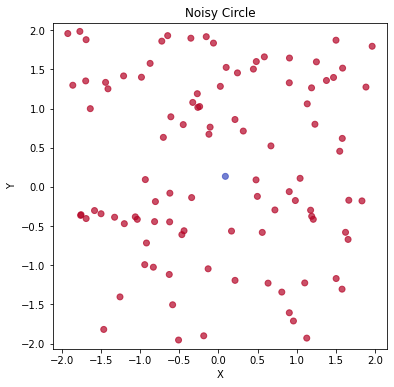

In [5]:
# Example data one circle
noise_scaled=0.10
num_points = 100
center = np.array([0,0])

x = np.random.uniform(-2, 2, size=(num_points, 2))
y = circle(x[:,0], x[:,1], radius=0.4, noise=noise_scaled, center=center)

plt.figure(figsize=(6, 6))
plt.scatter(x[:,0], x[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('Noisy Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

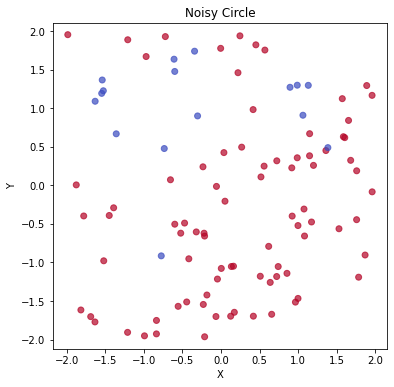

In [6]:
# Multiple circle example
x = np.random.uniform(-2, 2, size=(num_points, 2))
y = multiple_circles(x0=x[:,0], x1=x[:,1], radius=[0.5, 0.3, 0.8],
                     noise= [0.1, 0.01, 0.2], 
                     center=[[1, 1], [-1, -1], [-1, 1]])

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(x[:,0], x[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('Noisy Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

In [7]:
import trieste
from online_neuro.utils import CustomMinMaxScaler, SearchSpacePipeline
from trieste.data import Dataset

# Partially initialize the function. 
# Replace init_fun with a class/call that returns either 0,1 for a classification problrm, or a continuous value to minimize/maximize
init_fun = partial(multiple_circles, radius=[0.5, 0.8, 1],
                   noise= [0.1, 0.15, 0.1],
                   center=[[1, 1], [-1, -1], [-1, 1]])

lb = [-2, -2]
ub = [2, 2]

search_space = trieste.space.Box(lower=[-1,-1],
                                 upper=[1,1])

#Don't worry about this odditiy, is used in the other problems as a single feature, i.e. position
# can have multiple dimensions pos_0 = [x0,y0], pos_1 = [x1,y1] , etc...
feature_map = {f'x_{i+1}':i for i in range(len(lb))}
feature_names = list(feature_map.keys())

scaler = CustomMinMaxScaler(feature_min=lb,
                            feature_max=ub,
                            output_range=(-1,1))

#search_space_pipe chains normalizing inputs/outputs and sampling methods (we want to see features in normal scale, but we want the BO to recieve normalized values).
search_space_pipe = SearchSpacePipeline(search_space=search_space,
                                        mapping=feature_map,
                                        feature_names=feature_names,
                                        scaler=scaler)

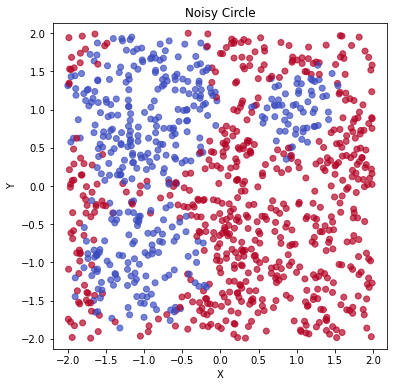

In [8]:
# The "Solution" observed a large amount of samples
x = np.random.uniform(-2, 2, size=(1000, 2))
y = init_fun(x[:,0], x[:,1])

plt.figure(figsize=(6, 6))
plt.scatter(x[:,0], x[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('Noisy Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

In [9]:
import pandas as pd
from online_neuro.utils import list_dict_process
from trieste.acquisition.function import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.observer import OBJECTIVE

In [10]:
search_space_pipe.search_space.upper,search_space_pipe.search_space.lower

(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1., -1.])>)

In [11]:
# Initial samples
init_samples = 50
qp_orig = search_space.sample(init_samples)
qp_orig = qp_orig.numpy()

if scaler:
    qp = scaler.inverse_transform(qp_orig)
    
col_names = ['x_1','x_2']
qp_df = pd.DataFrame(qp, columns=col_names)

In [12]:
# First observations
observations = init_fun(qp[:,0], qp[:,1])
observations = np.atleast_2d(observations).reshape(-1,1)
qp_df['observation'] = observations


In [13]:
qp.min(axis=0), qp.max(axis=0)

(array([-1.84962314, -1.99556315]), array([1.99490036, 1.91685207]))

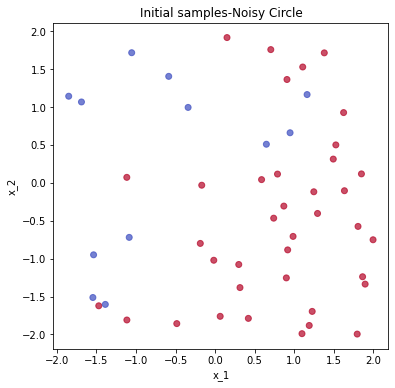

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(qp_df[col_names[0]], qp_df[col_names[1]], c=qp_df['observation'],
            cmap='coolwarm', alpha=0.7)
plt.xlabel(col_names[0])
plt.ylabel(col_names[1])
#plt.axis('equal')
plt.title("Initial samples-Noisy Circle")
plt.show()

In [15]:
# @Note. For some tensorflow reason observations need to be float even for classification problems.
# Trieste Dataset (X,y)
init_dataset = Dataset(query_points=tf.cast(qp_orig, tf.float64),
                       observations=tf.cast(observations, tf.float64))


In [16]:
# Methods that specify the type of model and acquisition functiopn
model_config = {'classification':True,
                'variational':True,
                'sparse':False,
                'trainable_likelihood':True,
                'noise_free':True,
               }

online_model = build_model(init_dataset,
                           search_space_pipe.search_space,
                           model_config)

acq = BayesianActiveLearningByDisagreement()
rule = EfficientGlobalOptimization(builder=acq,
                                   num_query_points=1 #A lot of models can only query 1 point at a time.
                                   )

ask_tell = AskTellOptimizer(search_space = search_space_pipe.search_space,
                            datasets=init_dataset,
                            models=online_model,
                            acquisition_rule=rule,
                            fit_model = True)

In [17]:
max_iters = 50
iter = 0

init_df = qp_df.copy()
qp_dfs = []
while iter <= max_iters:
    print(f"{iter}/{max_iters}",end='\r')
    #Request point to sample
    qp_orig = ask_tell.ask()
    qp_orig = qp_orig.numpy()

    if scaler:
        qp = scaler.inverse_transform(qp_orig)
        
    observations = init_fun(x0=qp[:,0], x1=qp[:,1])
    
    if observations.ndim == 1:
        observations = observations.reshape(-1,1)
    
    tagged_output = Dataset(query_points=tf.cast(qp_orig, tf.float64), 
                            observations=tf.cast(observations, tf.float64))
    qp_df = pd.DataFrame(qp, columns = col_names)

    qp_df['observation'] = observations
    qp_dfs.append(qp_df)
    
    #First iteration (outside of the loop, it can also be done inside tho)
    ask_tell.tell(tagged_output)
    
    iter += 1

In [18]:
qp_dfs = pd.concat(qp_dfs, ignore_index=True)

In [19]:
qp_dfs.head(3)

,x_1,x_2,observation
0,-2.0,0.477552,1
1,-2.0,-0.422099,1
2,-2.0,2.000000,1


In [20]:
init_df.head(3)

,x_1,x_2,observation
0,-1.544245,-1.513130,0
1,-1.469868,-1.622524,1
2,-1.054017,1.716955,0


In [21]:
init_df.shape, qp_dfs.shape

((50, 3), (51, 3))

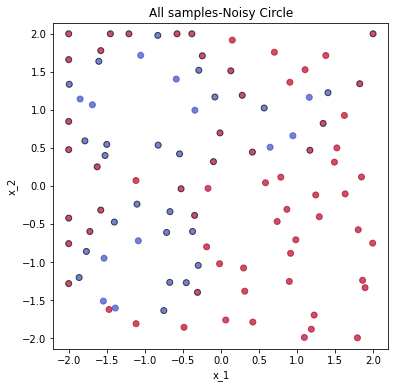

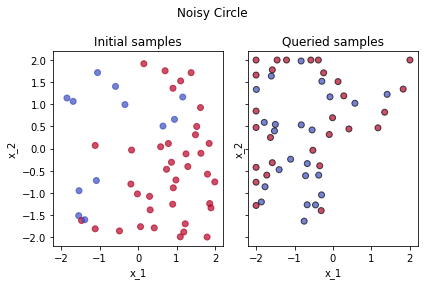

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(init_df['x_1'], init_df['x_2'], c=init_df['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
plt.scatter(qp_dfs['x_1'], qp_dfs['x_2'], c=qp_dfs['observation']+2,
            cmap='coolwarm', alpha=0.7, label='collected_samples',
           edgecolors='black')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.axis('equal')
plt.title("All samples-Noisy Circle")
plt.show()

fig, ax = plt.subplots(figsize=(6, 4), ncols=2, sharey=True, sharex=True)
ax[0].scatter(init_df['x_1'], init_df['x_2'], c=init_df['observation'],
            cmap='coolwarm', alpha=0.7, label='init_samples')
ax[1].scatter(qp_dfs['x_1'], qp_dfs['x_2'], c=qp_dfs['observation']+2,
            cmap='coolwarm', alpha=0.7, label='collected_samples',
           edgecolors='black')
ax[0].set_xlabel('x_1')
ax[1].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[1].set_ylabel('x_2')
ax[0].set_title("Initial samples")
ax[1].set_title("Queried samples")
fig.suptitle("Noisy Circle")
fig.tight_layout()
plt.show()

In [23]:
ask_tell.datasets.keys()

dict_keys(['OBJECTIVE'])

In [24]:
ask_tell.model.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,True,(),float64,9.89358
VGP.kernel.variance,Parameter,Softplus,,False,(),float64,100.0
VGP.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(2,)",float64,[0.53997531 0.48106941]
VGP.data[0],ResourceVariable,,,False,"(None, 2)",float64,"[[-0.77212245, -0.75656486..."
VGP.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[0....
VGP.num_data,Parameter,Identity,,False,(),int32,101
VGP.q_mu,Parameter,Identity,,True,"(None, 1)",float64,[[-1.13669...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, None, None)",float64,"[[[1.05308863e-01, 0.00000000e+00, 0.00000000e+00..."
